d:\anaconda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\anaconda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
d:\anaconda\Lib\site-packages\ultralytics\nn\tasks.py:733: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more de


0: 640x640 1 Speed Limit 60, 20.0ms
Speed: 3.0ms preprocess, 20.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Speed Limit 60, 12.2ms
Speed: 3.0ms preprocess, 12.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Speed Limit 60, 12.0ms
Speed: 3.0ms preprocess, 12.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
Epsilon 0.000 - FGSM: 0.9529, PGD: 0.9529, BIM: 0.9529

0: 640x640 1 Speed Limit 60, 13.1ms
Speed: 3.0ms preprocess, 13.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Speed Limit 60, 13.1ms
Speed: 2.5ms preprocess, 13.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Speed Limit 60, 13.2ms
Speed: 3.0ms preprocess, 13.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Epsilon 0.020 - FGSM: 0.9398, PGD: 0.9500, BIM: 0.9490

0: 640x640 1 Speed Limit 60, 13.3ms
Speed: 2.0ms preprocess, 13.3ms inference, 1.0ms 

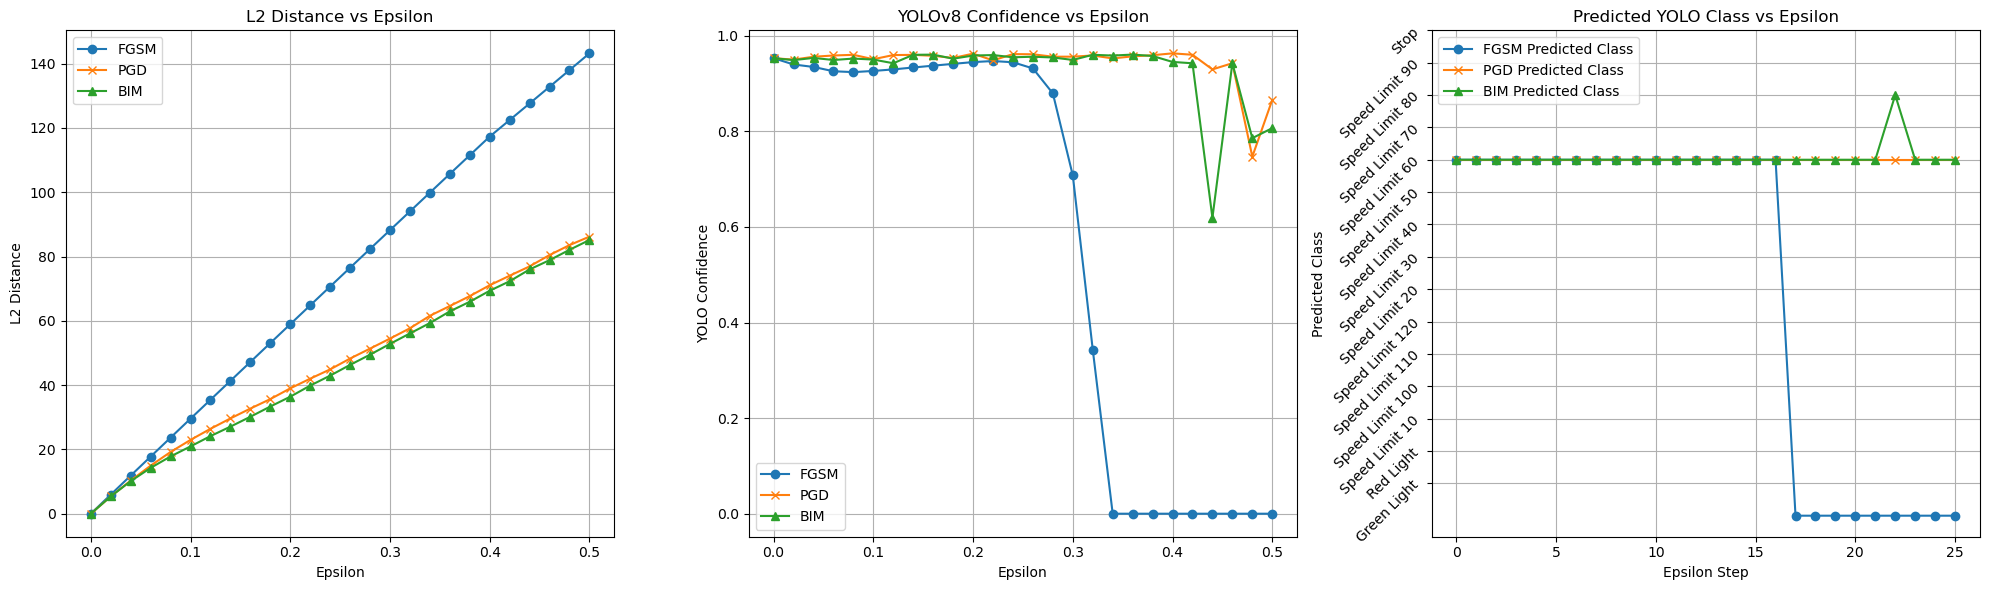

In [2]:
import torch
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from ultralytics import YOLO
import os
import csv

class AdversarialAttackYOLO:
    def __init__(self, yolo_weights_path, device=None):
        self.device = device or ('cuda' if torch.cuda.is_available() else 'cpu')
        self.YOLO_CLASSES = ['Green Light', 'Red Light', 'Speed Limit 10', 'Speed Limit 100', 'Speed Limit 110',
                            'Speed Limit 120', 'Speed Limit 20', 'Speed Limit 30', 'Speed Limit 40', 'Speed Limit 50',
                            'Speed Limit 60', 'Speed Limit 70', 'Speed Limit 80', 'Speed Limit 90', 'Stop']

        self.resnet = models.resnet18(pretrained=True).to(self.device).eval()
        self.yolo = YOLO(yolo_weights_path)
        self.preprocess = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
        ])

    def load_image(self, image_path):
        img = Image.open(image_path).convert('RGB')
        tensor = self.preprocess(img).unsqueeze(0).to(self.device)
        return tensor, img

    def save_image(self, tensor, save_path):
        img = transforms.ToPILImage()(tensor.squeeze().cpu())
        img.save(save_path)

    def class_to_idx(self, cls_name):
        if cls_name in self.YOLO_CLASSES:
            return self.YOLO_CLASSES.index(cls_name)
        return -1  # None 類別

    def get_yolo_conf_and_class(self, image_pil):
        with torch.no_grad():
            results = self.yolo(image_pil)
        boxes = results[0].boxes
        if len(boxes) > 0:
            confs = [box.conf.item() for box in boxes]
            classes = [int(box.cls.item()) for box in boxes]
            avg_conf = np.mean(confs)
            main_class = self.YOLO_CLASSES[classes[0]]
            return avg_conf, main_class
        else:
            return 0.0, "None"

    def fgsm_attack(self, image, epsilon, label):
        image = image.clone().detach().requires_grad_(True)
        output = self.resnet(image)
        loss = F.nll_loss(F.log_softmax(output, dim=1), label)
        self.resnet.zero_grad()
        loss.backward()
        data_grad = image.grad.data
        perturbed = image + epsilon * data_grad.sign()
        return torch.clamp(perturbed, 0, 1)

    def pgd_attack(self, image, label, epsilon, alpha=0.01, iters=40):
        ori_image = image.clone().detach()
        # 這裡初始加入隨機噪聲，讓擾動更豐富
        perturbed = ori_image + torch.empty_like(ori_image).uniform_(-epsilon, epsilon)
        perturbed = torch.clamp(perturbed, 0, 1)
        for _ in range(iters):
            perturbed = perturbed.clone().detach().requires_grad_(True)
            output = self.resnet(perturbed)
            loss = F.nll_loss(F.log_softmax(output, dim=1), label)
            self.resnet.zero_grad()
            loss.backward()
            grad = perturbed.grad.data
            perturbed = perturbed + alpha * grad.sign()
            perturbed = torch.max(torch.min(perturbed, ori_image + epsilon), ori_image - epsilon)
            perturbed = torch.clamp(perturbed, 0, 1).detach()
        return perturbed

    # ===== BIM 每步加躁聲標準差從0開始，每步加0.002 =====
    def bim_attack(self, image, label, epsilon, alpha=0.01, iters=10):
        ori_image = image.clone().detach()
        adv = ori_image + torch.empty_like(ori_image).uniform_(-epsilon, epsilon)
        adv = torch.clamp(adv, 0, 1).detach()
        
        for i in range(iters):
            adv = adv.clone().detach().requires_grad_(True)
            output = self.resnet(adv)
            loss = F.nll_loss(F.log_softmax(output, dim=1), label)
            self.resnet.zero_grad()
            loss.backward()
            grad = adv.grad.data
            adv = adv + alpha * grad.sign()
            # 動態噪聲標準差 i * 0.002
            noise_scale = i * 0.002
            noise = torch.empty_like(adv).normal_(mean=0, std=noise_scale)
            adv = adv + noise
            adv = torch.max(torch.min(adv, ori_image + epsilon), ori_image - epsilon)
            adv = torch.clamp(adv, 0, 1).detach()
        return adv

    def run_attacks(self, image_path, epsilons=None):
        if epsilons is None:
            epsilons = np.arange(0.0, 0.5 + 0.02, 0.02)  # 每步 0.02
        
        os.makedirs("adv_images/fgsm", exist_ok=True)
        os.makedirs("adv_images/pgd", exist_ok=True)
        os.makedirs("adv_images/bim", exist_ok=True)

        clean_tensor, original_pil = self.load_image(image_path)
        with torch.no_grad():
            output = self.resnet(clean_tensor)
            label = output.argmax(dim=1)

        fgsm_conf_list, pgd_conf_list, bim_conf_list = [], [], []
        fgsm_class_list, pgd_class_list, bim_class_list = [], [], []
        fgsm_l2_list, pgd_l2_list, bim_l2_list = [], [], []

        csv_path = "adv_images/attack_results.csv"
        with open(csv_path, mode='w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(["Epsilon", 
                             "FGSM_Conf", "FGSM_Class", "FGSM_L2", 
                             "PGD_Conf", "PGD_Class", "PGD_L2", 
                             "BIM_Conf", "BIM_Class", "BIM_L2"])

            for eps in epsilons:
                fgsm_img = self.fgsm_attack(clean_tensor, eps, label)
                fgsm_pil = transforms.ToPILImage()(fgsm_img.squeeze())
                fgsm_conf, fgsm_cls = self.get_yolo_conf_and_class(fgsm_pil)
                fgsm_l2 = torch.norm((fgsm_img - clean_tensor).view(1, -1)).item()
                self.save_image(fgsm_img, f"adv_images/fgsm/eps_{eps:.3f}.png")

                pgd_img = self.pgd_attack(clean_tensor, label, eps)
                pgd_pil = transforms.ToPILImage()(pgd_img.squeeze())
                pgd_conf, pgd_cls = self.get_yolo_conf_and_class(pgd_pil)
                pgd_l2 = torch.norm((pgd_img - clean_tensor).view(1, -1)).item()
                self.save_image(pgd_img, f"adv_images/pgd/eps_{eps:.3f}.png")

                bim_img = self.bim_attack(clean_tensor, label, eps)
                bim_pil = transforms.ToPILImage()(bim_img.squeeze())
                bim_conf, bim_cls = self.get_yolo_conf_and_class(bim_pil)
                bim_l2 = torch.norm((bim_img - clean_tensor).view(1, -1)).item()
                self.save_image(bim_img, f"adv_images/bim/eps_{eps:.3f}.png")

                writer.writerow([f"{eps:.4f}",
                                 f"{fgsm_conf:.4f}", fgsm_cls, f"{fgsm_l2:.4f}",
                                 f"{pgd_conf:.4f}", pgd_cls, f"{pgd_l2:.4f}",
                                 f"{bim_conf:.4f}", bim_cls, f"{bim_l2:.4f}"])

                fgsm_conf_list.append(fgsm_conf)
                pgd_conf_list.append(pgd_conf)
                bim_conf_list.append(bim_conf)

                fgsm_class_list.append(fgsm_cls)
                pgd_class_list.append(pgd_cls)
                bim_class_list.append(bim_cls)

                fgsm_l2_list.append(fgsm_l2)
                pgd_l2_list.append(pgd_l2)
                bim_l2_list.append(bim_l2)

                print(f"Epsilon {eps:.3f} - FGSM: {fgsm_conf:.4f}, PGD: {pgd_conf:.4f}, BIM: {bim_conf:.4f}")

        fgsm_class_idx = [self.class_to_idx(c) for c in fgsm_class_list]
        pgd_class_idx = [self.class_to_idx(c) for c in pgd_class_list]
        bim_class_idx = [self.class_to_idx(c) for c in bim_class_list]

        plt.figure(figsize=(20, 6))

        plt.subplot(1, 3, 1)
        plt.plot(epsilons, fgsm_l2_list, label="FGSM", marker='o')
        plt.plot(epsilons, pgd_l2_list, label="PGD", marker='x')
        plt.plot(epsilons, bim_l2_list, label="BIM", marker='^')
        plt.title("L2 Distance vs Epsilon")
        plt.xlabel("Epsilon")
        plt.ylabel("L2 Distance")
        plt.legend()
        plt.grid(True)

        plt.subplot(1, 3, 2)
        plt.plot(epsilons, fgsm_conf_list, label="FGSM", marker='o')
        plt.plot(epsilons, pgd_conf_list, label="PGD", marker='x')
        plt.plot(epsilons, bim_conf_list, label="BIM", marker='^')
        plt.title("YOLOv8 Confidence vs Epsilon")
        plt.xlabel("Epsilon")
        plt.ylabel("YOLO Confidence")
        plt.legend()
        plt.grid(True)

        plt.subplot(1, 3, 3)
        plt.plot(fgsm_class_idx, label="FGSM Predicted Class", marker='o')
        plt.plot(pgd_class_idx, label="PGD Predicted Class", marker='x')
        plt.plot(bim_class_idx, label="BIM Predicted Class", marker='^')
        plt.title("Predicted YOLO Class vs Epsilon")
        plt.xlabel("Epsilon Step")
        plt.ylabel("Predicted Class")
        plt.legend()
        plt.grid(True)
        plt.yticks(range(len(self.YOLO_CLASSES)), self.YOLO_CLASSES, rotation=45)

        plt.tight_layout()
        plt.savefig("adv_images/attack_comparison_all.png")
        plt.show()


if __name__ == "__main__":
    attack_obj = AdversarialAttackYOLO(r"D:\Code\cybersecurity\AIS3 2025 project new\best.pt", device='cuda')
    attack_obj.run_attacks(r"D:\Code\cybersecurity\AIS3 2025 project new\Taiwan_road_sign_r5-60.svg.png")
